In [69]:
# Incluir las bibliotecas requeridas para el preprocesamiento
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from boruta import BorutaPy
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

In [7]:
# URL del archivo CSV público en S3
url = 'https://diabetes-dvcstore.s3.us-east-1.amazonaws.com/files/md5/0c/84b09d240b72e8180bceff3965d1bd'
# Carga el archivo de la primera versión de datos directamente en un DataFrame de pandas
df = pd.read_csv(url)
 
# Verifica el DataFrame cargado
print(df.shape)
df.head()

(253680, 22)


,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


(251437, 22)


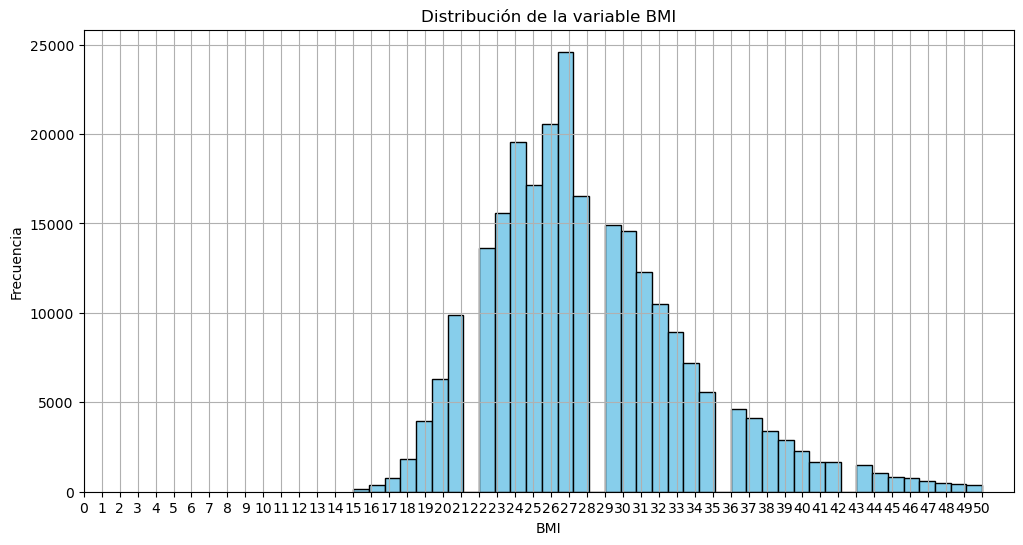

In [9]:
# Considerando la descripción de datos, seleccionar los registros que se encuentren en el intervalo de la variable BMI
# 15<BMI<50, valores plausibles de BMI según la OMS
df = df.loc[(df['BMI'] >= 15) & (df['BMI'] <= 50)]
print(df.shape)

# Distribucíón de la variable BMI
# Configurar la figura
plt.figure(figsize=(12, 6))

# Crear el histograma para la variable 'BMI'
df['BMI'].hist(bins=40, color='skyblue', edgecolor='black')

# Etiquetas y título
plt.title('Distribución de la variable BMI')
plt.xlabel('BMI')
plt.ylabel('Frecuencia')
plt.xticks(range(0, int(df['BMI'].max()) + 1, 1))

plt.show()

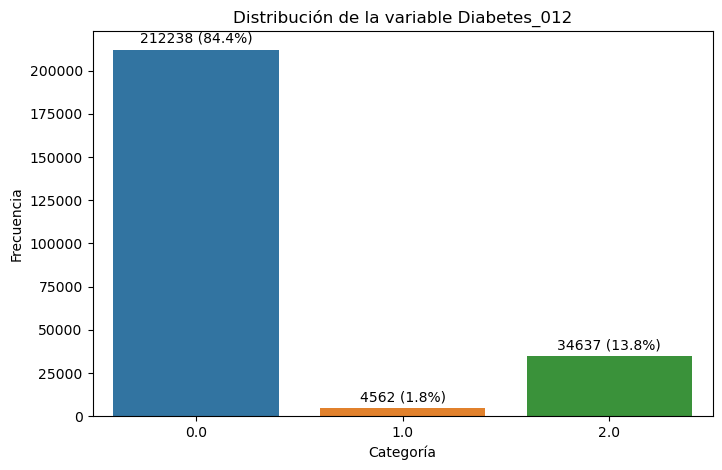

In [4]:
# Gráfica de distribución de la variable de respuesta 'Diabetes_012'
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='Diabetes_012', data=df)
plt.title('Distribución de la variable Diabetes_012')
plt.xlabel('Categoría')
plt.ylabel('Frecuencia')

# Calcular el total de registros para obtener los porcentajes
total = len(df)

# Agregar el valor del conteo y el porcentaje en la misma línea para cada barra
for p in ax.patches:
    count = int(p.get_height())  # El valor del conteo
    percentage = 100 * count / total  # Calcular el porcentaje
    ax.annotate(f'{count} ({percentage:.1f}%)', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.show()

(69274, 22)


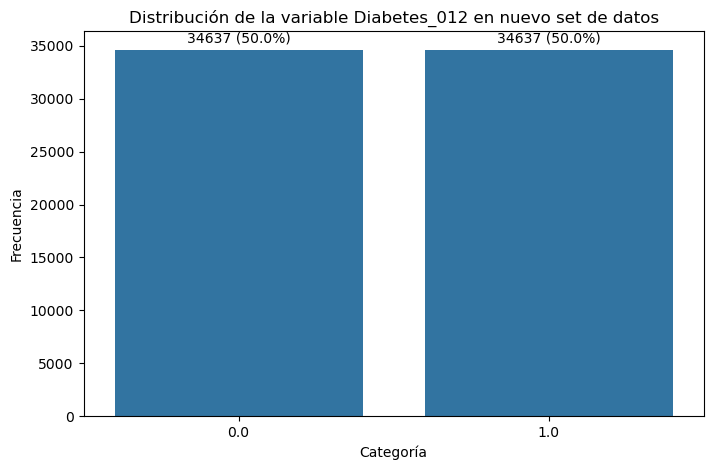

In [11]:
# Dado el desbalance que se tiene por el alto nivel de registros con personas sin diabetes (valor 0)
# y el bajo nivel de la categoría de prediabetes (valor 1) en el set de datos, se tomará una muestra aleatoria 
# de la categoría 0 equivalente al número de registros de la categoría 2, dejando estos dos grupos de registros (0 y 2)
#  como el nuevo set de datos y se renombrará la categoría 2 (tiene diabetes) a 1.
# Tomar una muestra aleatoria de 34637 registros con Diabetes_012 igual a 0
sample_0 = df[df['Diabetes_012'] == 0].sample(n=34637, random_state=42)

# Seleccionar todos los registros donde Diabetes_012 es igual a 2
data_2 = df[df['Diabetes_012'] == 2]

# Combinar ambos conjuntos de datos en un nuevo DataFrame
new_df = pd.concat([sample_0, data_2])

# Opcional: Reiniciar el índice si es necesario
new_df = new_df.reset_index(drop=True)

# Cambiar el valor de Diabetes_012 de 2 a 1 en el nuevo DataFrame
new_df.loc[new_df['Diabetes_012'] == 2, 'Diabetes_012'] = 1
print(new_df.shape)

# Gráfica de distribución de la variable de respuesta 'Diabetes_012' para el nuevo set de datos
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='Diabetes_012', data=new_df)
plt.title('Distribución de la variable Diabetes_012 en nuevo set de datos')
plt.xlabel('Categoría')
plt.ylabel('Frecuencia')

# Calcular el total de registros para obtener los porcentajes
total = len(new_df)

# Agregar el valor del conteo y el porcentaje en la misma línea para cada barra
for p in ax.patches:
    count = int(p.get_height())  # El valor del conteo
    percentage = 100 * count / total  # Calcular el porcentaje
    ax.annotate(f'{count} ({percentage:.1f}%)', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.show()

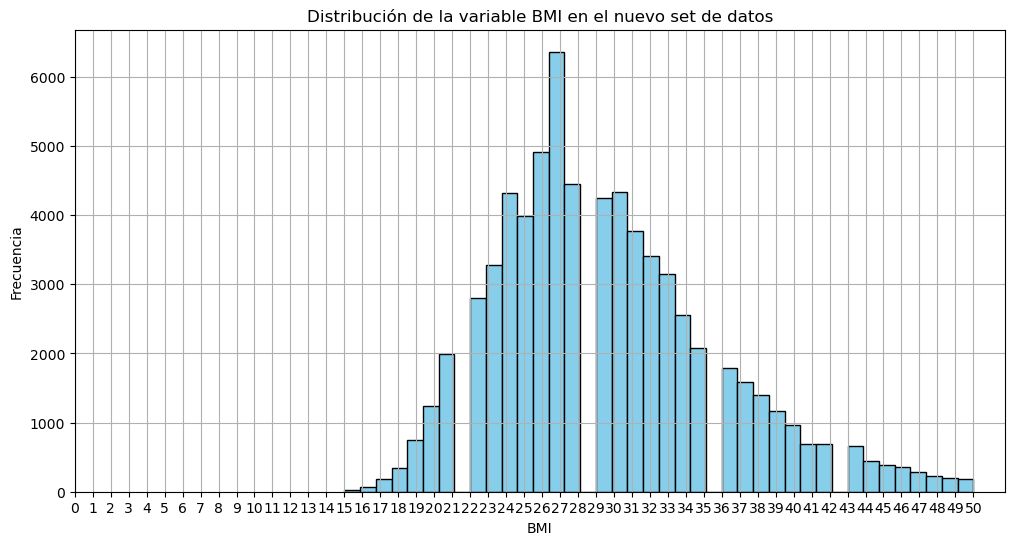

In [6]:
# Distribucíón de la variable BMI en el nuevo set de datos
# Configurar la figura
plt.figure(figsize=(12, 6))

# Crear el histograma para la variable 'BMI'
new_df['BMI'].hist(bins=40, color='skyblue', edgecolor='black')

# Etiquetas y título
plt.title('Distribución de la variable BMI en el nuevo set de datos')
plt.xlabel('BMI')
plt.ylabel('Frecuencia')
plt.xticks(range(0, int(df['BMI'].max()) + 1, 1))

plt.show()

In [13]:
#Preparación del set de datos para aplicar métodos de selección de variables para el nuevo set de datos
y=new_df[['Diabetes_012']]
X=new_df.drop(columns=['Diabetes_012'])
print(X.shape)
print(y.shape)

(69274, 21)
(69274, 1)


In [15]:
#Definición de los set de entrenamiento y muestra

# Dividir los datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Imprimir las dimensiones de los conjuntos de datos resultantes
print(f"Datos de entrenamiento: {X_train.shape}, Datos de prueba: {X_test.shape}")

Datos de entrenamiento: (51955, 21), Datos de prueba: (17319, 21)


Exactitud del modelo sin RFE: 0.7514


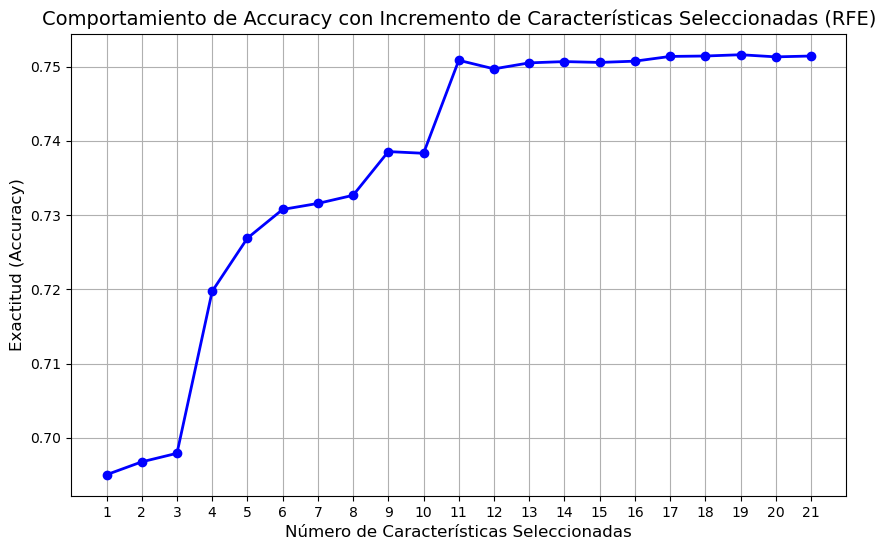

C:\Users\509870\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\509870\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\509870\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


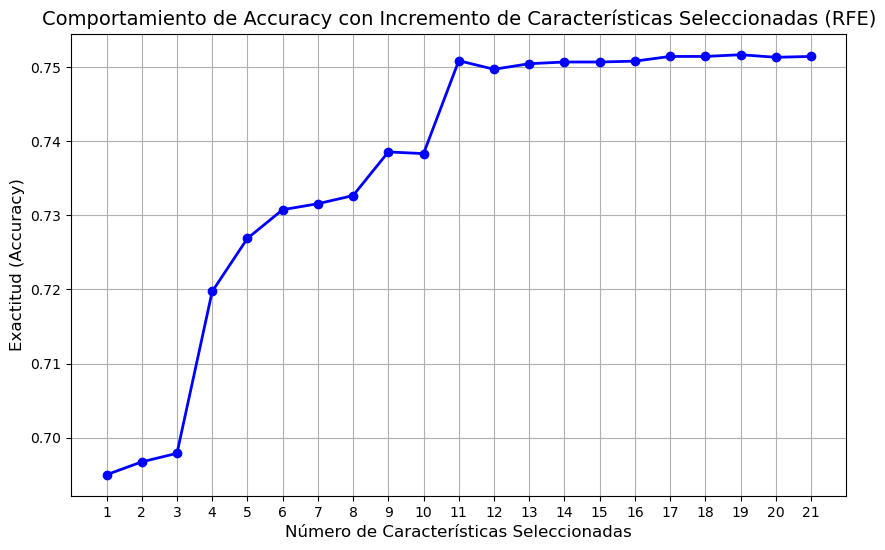

In [49]:
# Aplicación de RFE para la selección de las variables más representativas para el modelo
# Crear un modelo base (regresión logística en este caso)
model = LogisticRegression(solver='liblinear')
# Evaluar el modelo sin RFE
model.fit(X_train, y_train.values.ravel())
accuracy = model.score(X_test, y_test)
print(f"Exactitud del modelo sin RFE: {accuracy:.4f}")

# Lista para almacenar los resultados
accuracies = []
feature_counts = range(1, X_train.shape[1] + 1)  # Incrementar desde 1 hasta el número total de características

# Evaluar el modelo para diferentes valores de n_features_to_select
for n_features in feature_counts:
    # Aplicar RFE
    rfe = RFE(estimator=model, n_features_to_select=n_features)
    rfe.fit(X_train, y_train.values.ravel())

    # Obtener las características seleccionadas
    selected_features = X_train.columns[rfe.support_]

    # Evaluar el modelo usando las características seleccionadas
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]
    
    # Entrenar el modelo con las características seleccionadas
    model.fit(X_train_selected, y_train.values.ravel())
    
    # Calcular el accuracy
    accuracy = model.score(X_test_selected, y_test)
    accuracies.append(accuracy)

# Graficar el accuracy en función de n_features_to_select
plt.figure(figsize=(10, 6))
plt.plot(feature_counts, accuracies, marker='o', color='b', linestyle='-', linewidth=2)
plt.title('Comportamiento de Accuracy con Incremento de Características Seleccionadas (RFE)', fontsize=14)
plt.xlabel('Número de Características Seleccionadas', fontsize=12)
plt.ylabel('Exactitud (Accuracy)', fontsize=12)
plt.grid(True)
plt.xticks(range(1, X_train.shape[1] + 1))  # Mostrar todas las opciones de número de características
plt.show()

In [51]:
# Aplicar RFE para seleccionar las mejores características a partir de la gráfica anterior
rfe = RFE(estimator=model, n_features_to_select=11)
rfe.fit(X_train, y_train.values.ravel())

# Obtener las características seleccionadas (True indica que la característica fue seleccionada)
selected_features = X_train.columns[rfe.support_]
print(f"Características seleccionadas: {selected_features}")

# Evaluar el modelo en el conjunto de prueba usando solo las características seleccionadas
X_train_selected_rfe = X_train[selected_features]
X_test_selected_rfe = X_test[selected_features]

# Entrenar el modelo con las características seleccionadas
model.fit(X_train_selected_rfe, y_train.values.ravel())

# Evaluar el modelo con las características seleccionadas
accuracy = model.score(X_test_selected_rfe, y_test)
print(f"Exactitud del modelo con RFE: {accuracy:.4f}")

Características seleccionadas: Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Stroke',
       'HeartDiseaseorAttack', 'Veggies', 'HvyAlcoholConsump', 'GenHlth',
       'Sex', 'Age'],
      dtype='object')
Exactitud del modelo con RFE: 0.7509


C:\Users\509870\AppData\Local\Temp\ipykernel_6904\3301206921.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf.fit(X_train, y_train)


Exactitud del modelo con todas las características: 0.7413
Feature: BMI, Importance: 0.17209776199773114
Feature: Age, Importance: 0.12722847591600164
Feature: GenHlth, Importance: 0.1087604099992912
Feature: Income, Importance: 0.08421578680151869
Feature: HighBP, Importance: 0.07292164411121212
Feature: PhysHlth, Importance: 0.06798101947543442
Feature: Education, Importance: 0.0577081362923
Feature: MentHlth, Importance: 0.05201790083084036
Feature: HighChol, Importance: 0.04014544957391834
Feature: Smoker, Importance: 0.028704525765499558
Feature: Fruits, Importance: 0.028209345820208395
Feature: Sex, Importance: 0.026550183962375903
Feature: DiffWalk, Importance: 0.02482041014077813
Feature: PhysActivity, Importance: 0.0232645717706318
Feature: Veggies, Importance: 0.02254045486841084
Feature: HeartDiseaseorAttack, Importance: 0.01917988172779502
Feature: NoDocbcCost, Importance: 0.011956423683534816
Feature: Stroke, Importance: 0.009878373630264503
Feature: HvyAlcoholConsump, Imp

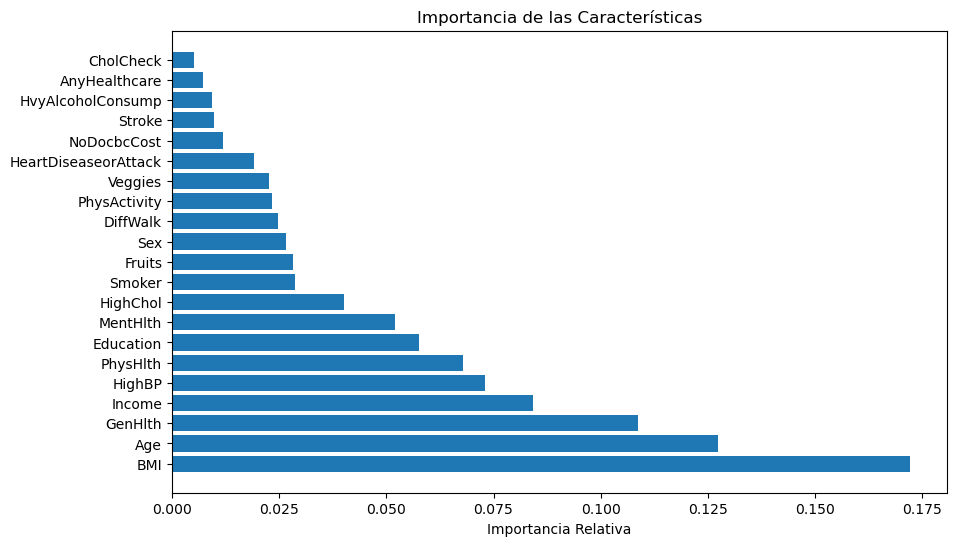

C:\Users\509870\AppData\Local\Temp\ipykernel_6904\3301206921.py:35: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf.fit(X_train_selected, y_train)


Exactitud del modelo con las características seleccionadas: 0.7289


In [11]:
# Aplicar Random Forest con el método feature_importances_
# Crear y entrenar el modelo de Random Forest
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
accuracy = model_rf.score(X_test, y_test)
print(f"Exactitud del modelo con todas las características: {accuracy:.4f}")

# Obtener la importancia de las características
importances = model_rf.feature_importances_

# Ordenar las características según su importancia
indices = importances.argsort()[::-1]

# Mostrar la importancia de las características en orden descendente
for i in range(X_train.shape[1]):
    print(f"Feature: {X_train.columns[indices[i]]}, Importance: {importances[indices[i]]}")

# Graficar la importancia de las características
plt.figure(figsize=(10, 6))
plt.title("Importancia de las Características")
plt.barh(range(X_train.shape[1]), importances[indices], align='center')
plt.yticks(range(X_train.shape[1]), X_train.columns[indices])
plt.xlabel("Importancia Relativa")
plt.show()

# Seleccionar las características más importantes
n_top_features = 11
top_features = X_train.columns[indices[:n_top_features]]

# Crear un nuevo conjunto de datos solo con las características más importantes
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

# Entrenar el modelo con las características seleccionadas
model_rf.fit(X_train_selected, y_train)

# Evaluar el modelo
accuracy = model_rf.score(X_test_selected, y_test)
print(f"Exactitud del modelo con las características seleccionadas: {accuracy:.4f}")

In [12]:
# Entrenar el modelo con las características seleccionadas
model.fit(X_train_selected, y_train)

# Evaluar el modelo
accuracy = model.score(X_test_selected, y_test)
print(f"Exactitud del modelo con las características seleccionadas: {accuracy:.4f}")

C:\Users\509870\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Exactitud del modelo con las características seleccionadas: 0.7459


In [13]:
# Entrenar el modelo con las características seleccionadas
model_rf.fit(X_train_selected_rfe, y_train)

# Evaluar el modelo
accuracy = model_rf.score(X_test_selected_rfe, y_test)
print(f"Exactitud del modelo con las características seleccionadas: {accuracy:.4f}")

C:\Users\509870\AppData\Local\Temp\ipykernel_6904\3165115854.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf.fit(X_train_selected_rfe, y_train)


Exactitud del modelo con las características seleccionadas: 0.7149


Exactitud del modelo con todas las variables: 0.7508
0                   HighBP
13                 GenHlth
1                 HighChol
2                CholCheck
18                     Age
10       HvyAlcoholConsump
3                      BMI
6     HeartDiseaseorAttack
16                DiffWalk
17                     Sex
20                  Income
Name: Feature, dtype: object


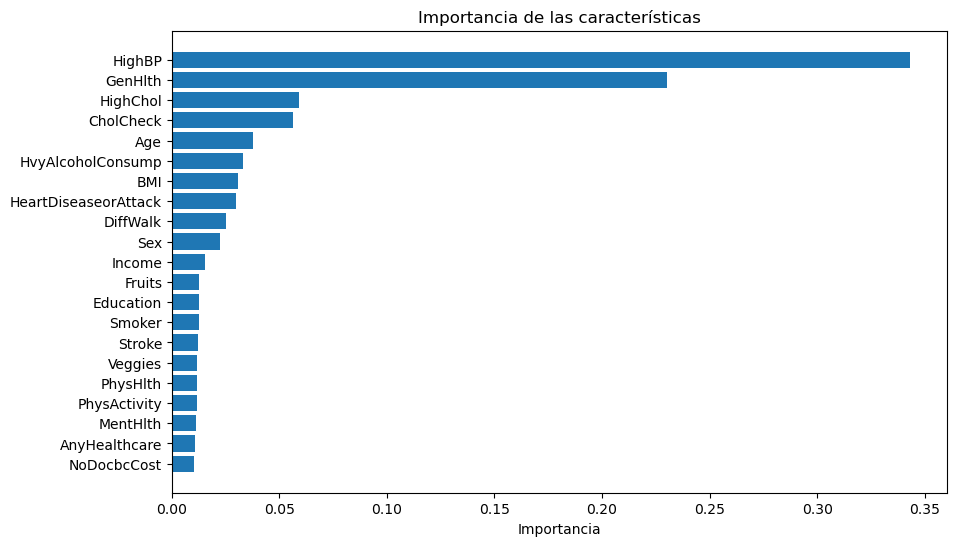

Exactitud del modelo con las características seleccionadas: 0.7495


In [18]:
# Selección de variables con XGBoost

model_XGBC = XGBClassifier()
model_XGBC.fit(X_train, y_train)
accuracy = model_XGBC.score(X_test, y_test)
print(f"Exactitud del modelo con todas las variables: {accuracy:.4f}")

importances = model_XGBC.feature_importances_

# Crear un DataFrame con las importancias
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Ordenar las características por importancia y seleccionar las top 11
top_features = importance_df.sort_values(by='Importance', ascending=False).head(11)['Feature']
print(top_features)


# Crear gráfico de barras

# Ordenar las importancias de mayor a menor
sorted_idx = np.argsort(importances)

# Crear gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances[sorted_idx], align='center')
plt.yticks(range(len(importances)), X.columns[sorted_idx])  # Reordenar las etiquetas de las características
plt.xlabel('Importancia')
plt.title('Importancia de las características')
plt.show()

X_train_reduced = X_train[top_features]
X_test_reduced = X_test[top_features]

# Entrenar el modelo con las características seleccionadas
model_XGBC.fit(X_train_reduced, y_train)

# Evaluar el modelo
accuracy = model_XGBC.score(X_test_reduced, y_test)
print(f"Exactitud del modelo con las características seleccionadas: {accuracy:.4f}")

In [27]:
# Boruta con Random Forest sin fijar máxima profundidad
rf_sp = RandomForestClassifier(n_jobs=-1,  random_state=42) #max_depth=10,

# Boruta
boruta_rf_sp = BorutaPy(
    estimator=rf_sp,
    n_estimators='auto',
    random_state=42,
    alpha=0.05
)

# Fit Boruta
boruta_rf_sp.fit(X_train.values, y_train.values.ravel())

# feature selection by Boruta
selected_features = X_train.columns[boruta_rf_sp.support_]
print("Variables seleccionadas con Boruta RF (max_depth=None):", selected_features)

Variables seleccionadas con Boruta RF (max_depth=None): Index(['HighBP', 'BMI', 'GenHlth', 'Age'], dtype='object')


In [31]:
# Boruta con Random Forest max_depth=10
rf_10 = RandomForestClassifier(n_jobs=-1, max_depth=10, random_state=42) 

# Boruta
boruta_rf_10 = BorutaPy(
    estimator=rf_10,
    n_estimators='auto',
    random_state=42,
    alpha=0.05
)

# Fit Boruta
boruta_rf_10.fit(X_train.values, y_train.values.ravel())

# feature selection by Boruta
selected_features10 = X_train.columns[boruta_rf_10.support_]
print("Variables seleccionadas con Boruta RF (max_depth=10):", selected_features10)

Variables seleccionadas con Boruta RF (max_depth=10): Index(['HighBP', 'HighChol', 'BMI', 'HeartDiseaseorAttack', 'GenHlth',
       'PhysHlth', 'DiffWalk', 'Age', 'Income'],
      dtype='object')


In [39]:
# Boruta con XGBoost
xgb_model = XGBClassifier( random_state=42)

# Boruta usando XGBoost
boruta_xgb = BorutaPy(xgb_model, n_estimators='auto', random_state=42)
boruta_xgb.fit(X_train.values, y_train.values.ravel())

# features selected by Boruta
selected_features_xgb = X_train.columns[boruta_xgb.support_]
print("Variables seleccionadas con Boruta RF (max_depth=10):", selected_features_xgb)

Variables seleccionadas con Boruta RF (max_depth=10): Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Stroke',
       'HeartDiseaseorAttack', 'HvyAlcoholConsump', 'GenHlth', 'DiffWalk',
       'Sex', 'Age', 'Income'],
      dtype='object')


In [63]:
# Se eligen las variables que más se repiten
# Se evalúa con un modelo XGBoost si se incluye o no la variable Income
carac_sin_income = ['HighBP','HighChol', 'BMI', 'Age', 'HeartDiseaseorAttack', 'GenHlth']
carac_con_income = ['HighBP','HighChol', 'BMI', 'Age', 'HeartDiseaseorAttack', 'GenHlth', 'Income']

In [79]:
# XGBoost sin income
xgb_model = XGBClassifier( random_state=42)

#Filtrar bases de train y test
X_train_i = X_train[carac_sin_income]
X_test_i = X_test[carac_sin_income]

# Entrenar el modelo XGBoost
xgb_f = xgb_model.fit(X_train_i, y_train.values.ravel())

# predicciones y evaluar el modelo
y_pred = xgb_f.predict(X_test_i)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy del modelo sin incluir la variable income: {accuracy} ")
print(f"Reporte de métricas del modelo sin incluir la variable income")
print(classification_report(y_test, y_pred))

Accuracy del modelo sin incluir la variable income: 0.746521161729892 
Reporte de métricas del modelo sin incluir la variable income
              precision    recall  f1-score   support

         0.0       0.77      0.71      0.74      8629
         1.0       0.73      0.78      0.76      8690

    accuracy                           0.75     17319
   macro avg       0.75      0.75      0.75     17319
weighted avg       0.75      0.75      0.75     17319



In [81]:
# XGBoost con income
xgb_model = XGBClassifier( random_state=42)

#Filtrar bases de train y test
X_train_i = X_train[carac_con_income]
X_test_i = X_test[carac_con_income]

# Entrenar el modelo XGBoost
xgb_f = xgb_model.fit(X_train_i, y_train.values.ravel())

# predicciones y evaluar el modelo
y_pred = xgb_f.predict(X_test_i)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy del modelo con la variable income: {accuracy} ")
print(f"Reporte de métricas del modelo con la variable income")
print(classification_report(y_test, y_pred))

Accuracy del modelo con la variable income: 0.7431722385819043 
Reporte de métricas del modelo con la variable income
              precision    recall  f1-score   support

         0.0       0.76      0.71      0.73      8629
         1.0       0.73      0.78      0.75      8690

    accuracy                           0.74     17319
   macro avg       0.74      0.74      0.74     17319
weighted avg       0.74      0.74      0.74     17319



In [83]:
# teniendo en cuenta que el modelo no mejora incluyendo la variable income, se decide no elegirla en las características finales 

# Características finales seleccionadas
caracteristicas_f = ['HighBP','HighChol', 'BMI', 'Age', 'HeartDiseaseorAttack', 'GenHlth']

df_final = new_df[caracteristicas_f]

df_final.head()

,HighBP,HighChol,BMI,Age,HeartDiseaseorAttack,GenHlth
0,0.0,0.0,21.0,8.0,0.0,1.0
1,1.0,1.0,25.0,10.0,0.0,3.0
2,1.0,0.0,23.0,11.0,0.0,2.0
3,0.0,1.0,26.0,10.0,0.0,1.0
4,0.0,1.0,25.0,7.0,0.0,1.0
